# Simulating Molecules using VQE

In this tutorial, we introduce the Variational Quantum Eigensolver (VQE), motivate its use, explain the necessary theory, and demonstrate its implementation in finding the ground state energy of molecules.

## Introduction

In many applications it is important to find the minimum eigenvalue of a matrix. For example, in chemistry, the minimum eigenvalue of a Hermitian matrix characterizing the molecule is the ground state energy of that system. In the future, the quantum phase estimation algorithm may be used to find the minimum eigenvalue. However, its implementation on useful problems requires circuit depths exceeding the limits of hardware available in the NISQ era. Thus, in 2014, Peruzzo *et al.* proposed VQE to estimate the ground state energy of a molecule using much shallower circuits [1]. 

Formally stated, given a Hermitian matrix $H$ with an unknown minimum eigenvalue $\lambda_{\text{min}}$, associated with the eigenstate $|\psi_{\text{min}}\rangle$, VQE provides an estimate $\lambda_{\theta}$ bounding $\lambda_{\text{min}}$:

$$
\begin{aligned}
    \lambda_{\text{min}} \le \lambda_{\theta} \equiv \langle \psi(\theta) |H|\psi(\theta) \rangle
\end{aligned}  
$$

where $|\psi(\theta)\rangle$ is the eigenstate associated with $\lambda_{\theta}$. By applying a parameterized circuit, represented by $U(\theta)$, to some arbitrary starting state $|\psi\rangle$, the algorithm obtains an estimate $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle$ on $|\psi_{\text{min}}\rangle$. The estimate is iteratively optimized by a classical controller changing the parameter $\theta$ minimizing the expectation value of $\langle \psi(\theta) |H|\psi(\theta) \rangle$.



## The Variational Method of Quantum Mechanics

### Mathematical Background

VQE is an application of the variational method of quantum mechanics. To better understand the variational method, some preliminary mathematical background is provided. An eigenvector, $|\psi_i\rangle$, of a matrix $A$ is invariant under transformation by $A$ up to a scalar multiplicative constant (the eigenvalue $\lambda_i$). That is,

$$
\begin{aligned}
    A |\psi_i\rangle = \lambda_i |\psi_i\rangle
\end{aligned}
$$

Furthermore, a matrix $H$ is Hermitian when it is equal to its own conjugate transpose.

$$
\begin{aligned}
    H = H^{\dagger}
\end{aligned}
$$

The spectral theorem states that the eigenvalues of a Hermitian matrix must be real. Thus, any eigenvalue of $H$ has the property that $ \lambda_i = \lambda_i^*$. As any measurable quantity must be real, Hermitian matrices are suitable for describing the Hamiltonians of quantum systems. Moreover, $H$ may be expressed as

$$
\begin{aligned}
    H = \sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |
\end{aligned}
$$

where each $\lambda_i$ is the eigenvalue corresponding to the eigenvector $|\psi_i\rangle$. Furthermore, the expectation value of the observable $H$ on an arbitrary quantum state $|\psi\rangle$ is given by 

$$
\begin{aligned}
    \langle H \rangle_{\psi} &\equiv \langle \psi | H | \psi \rangle
\end{aligned}
$$

Substituting $H$ with its representation as a weighted sum of its eigenvectors,

$$
\begin{aligned}
    \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle &= \langle \psi | \left(\sum_{i = 1}^{N} \lambda_i |\psi_i\rangle \langle \psi_i |\right) |\psi\rangle\\
    &= \sum_{i = 1}^{N} \lambda_i \langle \psi | \psi_i\rangle \langle \psi_i | \psi\rangle \\
    &= \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{aligned}
$$


The last equation demonstrates that the expectation value of an observable on any state can be expressed as a linear combination using the eigenvalues associated with $H$ as the weights. Moreover, each of the weights in the linear combination is greater than or equal to 0, as $| \langle \psi_i | \psi\rangle |^2 \ge 0$ and so it is clear that

$$
\begin{aligned}
    \lambda_{\text{min}} \le \langle H \rangle_{\psi} = \langle \psi | H | \psi \rangle = \sum_{i = 1}^{N} \lambda_i | \langle \psi_i | \psi\rangle |^2
\end{aligned}
$$

The above equation is known as the **variational method** (in some texts it is also known as the variational principle) [2]. It is important to note that this implies that the expectation value of any wave function will always be at least the minimum eigenvalue associated with $H$. Moreover, the expectation value of the eigenstate $|\psi_{\text{min}}\rangle$ is given by $ \langle \psi_{\text{min}}|H|\psi_{\text{min}}\rangle = \langle \psi_{\text{min}}|\lambda_{\text{min}}|\psi_{\text{min}}\rangle = \lambda_{\text{min}}$. Thus, as expected, $ \langle H \rangle_{\psi_{\text{min}}}=\lambda_{\text{min}}$.

### Bounding the Ground State

When the Hamiltonian of a system is described by the Hermitian matrix $H$ the ground state energy of that system, $E_{gs}$, is the smallest eigenvalue associated with $H$. Selecting any wave function $|\psi \rangle$ (called an *ansatz*) as an initial guess for $|\psi_{\text{min}}\rangle$, calculating its expectation value, $\langle H \rangle_{\psi}$, and iteratively updating the wave function, we can get arbitrarily tight bounds on the ground state energy of a Hamiltonian.

## The Variational Quantum Eigensolver

### Variational Forms

A systematic approach to varying the ansatz is required to implement the variational method on a quantum computer. VQE does so through the use of a parameterized circuit with a fixed form. Such a circuit is often called a *variational form*, and its action may be represented by the linear transformation $U(\theta)$. A variational form is applied to a starting state $|\psi\rangle$ (such as the vacuum state $|0\rangle$, or the Hartree Fock state) and generates an output state $U(\theta)|\psi\rangle\equiv |\psi(\theta)\rangle$. Iterative optimization over $|\psi(\theta)\rangle$ aims to yield an expectation value $ \langle \psi(\theta)|H|\psi(\theta)\rangle \approx E_{gs} \equiv \lambda_{\text{min}}$. Ideally, $|\psi(\theta)\rangle$ will be close to $|\psi_{\text{min}}\rangle$ (where 'closeness' is characterized by either state fidelity, or Manhattan distance) although in practice, useful bounds on $E_{gs}$ can be obtained even if this is not the case.

Moreover, a fixed variational form with a polynomial number of parameters can only generate transformations to a polynomially sized subspace of all the states in an exponentially sized Hilbert space. Consequently, various variational forms exist. Some, such as Ry and RyRz are heuristically designed, without consideration of the target domain. Others, such as UCCSD, utilize domain specific knowledge to generate close approximations based on the problem's structure. The structure of common variational forms is discussed in greater depth later in this document. 

### Simple Variational Forms

When constructing a variational form we must balance two opposing goals. Ideally, our $n$ qubit variational form would be able to generate any possible state $|\psi\rangle$ where $|\psi\rangle \in \mathbb{C}^N$ and $N=2^n$. However, we would like the variational form to use as few parameters as possible. Here, we aim to give intuition for the construction of variational forms satisfying our first goal, while disregarding the second goal for the sake of simplicity. 

Consider the case where $n=1$. The U3 gate takes three parameters, $\theta, \phi$ and $\lambda$, and represents the following transformation:

$$
\begin{aligned}
    U3(\theta, \phi, \lambda) = \begin{pmatrix}\cos(\frac{\theta}{2}) & -e^{i\lambda}\sin(\frac{\theta}{2}) \\ e^{i\phi}\sin(\frac{\theta}{2}) & e^{i\lambda + i\phi}\cos(\frac{\theta}{2}) \end{pmatrix}
\end{aligned}
$$

Up to a global phase, any possible single qubit transformation may be implemented by appropriately setting these parameters. Consequently, for the single qubit case, a variational form capable of generating any possible state is given by the circuit:

![image1](images/U3_var_form.png)


Moreover, this universal 'variational form' only has 3 parameters and thus can be efficiently optimized. It is worth emphasizing that the ability to generate an arbitrary state ensures that during the optimization process, the variational form does not limit the set of attainable states over which the expectation value of $H$ can be taken. Ideally, this ensures that the minimum expectation value is limited only by the capabilities of the classical optimizer. 

A less trivial universal variational form may be derived for the 2 qubit case, where two body interactions, and thus entanglement, must be considered to achieve universality. Based on the work presented by *Shende et al.* [3] the following is an example of a universal parameterized 2 qubit circuit:

![image2](images/two_qubit_var_form.png)
     
Allow the transformation performed by the above circuit to be represented by $U(\theta)$. When optimized, the expectation value of $H$ is minimized when $U(\theta)|\psi\rangle \equiv |\psi(\theta)\rangle \approx |\psi_{\text{min}}\rangle$. By formulation, $U(\theta)$ may produce a transformation to any possible state, and so this variational form may obtain an arbitrarily tight bound on two qubit ground state energies, only limited by the capabilities of the classical optimizer.

### Parameter Optimization

Once an efficiently parameterized variational form has been selected, in accordance with the variational method, its parameters must be optimized to minimize the expectation value of the target Hamiltonian. The parameter optimization process has various challenges. For example, quantum hardware has various types of noise and so objective function evaluation (energy calculation) may not necessarily reflect the true objective function. Additionally, some optimizers perform a number of objective function evaluations dependent on cardinality of the parameter set. An appropriate optimizer should be selected by considering the requirements of an application.

A popular optimization strategy is gradient descent where each parameter is updated in the direction yielding the largest local change in energy. Consequently, the number of evaluations performed depends on the number of optimization parameters present. This allows the algorithm to quickly find a local optimum in the search space. However, this optimization strategy often gets stuck at poor local optima, and is relatively expensive in terms of the number of circuit evaluations performed. While an intuitive optimization strategy, it is not recommended for use in VQE.

An appropriate optimizer for optimizing a noisy objective function is the *Simultaneous Perturbation Stochastic Approximation* optimizer (SPSA). SPSA approximates the gradient of the objective function with only two measurements. It does so by concurrently perturbing all the parameters in a random fashion, in contrast to gradient descent where each parameter is perturbed independently. When utilizing VQE in either a noisy simulator or on real hardware, SPSA is recommended as the classical optimizer.

When noise is not present in the cost function evaluation (such as when using VQE on a perfect simulator), a wide variety of classical optimizers may be useful. Two such optimizers supported by Qiskit are the *Sequential Least Squares Programming* optimizer (SLSQP) and the *Constrained Optimization by Linear Approximation* optimizer (COBYLA). It is worth noting that COBYLA only performs one objective function evaluation per optimization iteration (and thus the number of evaluations is independent of the parameter set's cardinality). Therefore, if the objective function is noise-free and minimizing the number of performed evaluations is desirable, it is recommended to try COBYLA. 

### Example with a Single Qubit Variational Form

We will now use the simple single qubit variational form to solve a problem similar to ground state energy estimation. Specifically, given a random probability vector $\vec{x}$, we want to determine a parameterization for our single qubit variational form that outputs a probability distribution close to $\vec{x}$ (where closeness is the Manhattan distance between the two probability vectors).

We first create the random probability distribution in Python:

In [9]:
# pylint: disable=missing-function-docstring
import numpy as np

np.random.seed(999999)
p0 = np.random.random()
target_distr = {0: p0, 1: 1 - p0}

We subsequently create a function that takes the parameters of our single U3 variational form as arguments and returns the corresponding quantum circuit:

In [10]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Parameter

params = [Parameter("theta"), Parameter("phi"), Parameter("lam")]


def get_var_form(params):
    qr = QuantumRegister(1, name="q")
    cr = ClassicalRegister(1, name="c")
    qc = QuantumCircuit(qr, cr)
    qc.u(params[0], params[1], params[2], qr[0])
    qc.measure(qr, cr[0])
    return qc


qc = get_var_form(params)

Now we specify the objective function which takes as input a list of the variational form's parameters, and returns the cost associated with those parameters:

In [ ]:
from qiskit_aer.primitives import Sampler

sampler = Sampler()


def objective_function(params):
    """Compares the output distribution of our circuit with
    parameters `params` to the target distribution."""
    # Simulate the circuit instance with paramters
    result = sampler.run(circuits=qc, parameter_values=params).result()
    # Get the quasi distribution for each measured state
    output_distr = result.quasi_dists[0]
    # Calculate the cost as the distance between the output
    # distribution and the target distribution
    cost = sum(
        abs(target_distr.get(i, 0) - output_distr.get(i, 0))
        for i in range(2**qc.num_qubits)
    )
    return cost

Finally, we create an instance of the COBYLA optimizer, and run the algorithm. Note that the output varies from run to run due to random noise. Moreover, while close, the obtained distribution will not be exactly the same as the target distribution.

In [12]:
from qiskit_algorithms.optimizers import SPSA, SLSQP, COBYLA

optimizer = COBYLA(maxiter=500, tol=0.0001)
# Create the initial parameters (noting that our
# single qubit variational form has 3 parameters)
initial_point = np.random.rand(3)

result = optimizer.minimize(fun=objective_function, x0=initial_point)

# Obtain the output distribution using the final parameters
output_distr = (
    sampler.run(circuits=qc, parameter_values=result.x)
    .result()
    .quasi_dists[0]
)

print("Parameters Found:", result.x)
print("Target Distribution:", target_distr)
print("Obtained Distribution:", output_distr)
print("Cost:", objective_function(result.x))

Parameters Found: [0.31572112 0.70200042 1.92758233]
Target Distribution: {0: 0.308979188922057, 1: 0.691020811077943}
Obtained Distribution: {1: 0.66796875, 0: 0.33203125}
Cost: 0.036338497155885996


### Structure of Common Variational Forms

As already discussed, it's impossible for a polynomially parameterized variational form to generate a transformation to any state. Variational forms can be grouped into two categories, depending on how they deal with this limitation. The first category of variational forms use domain or application specific knowledge to limit the set of possible output states. The second approach uses a heuristic circuit without prior domain or application specific knowledge. 

The first category of variational forms exploit characteristics of the problem domain to restrict the set of transformations that may be required. For example, when calculating the ground state energy of a molecule, the number of particles in the system is known *a priori*. Therefore, if a starting state with the correct number of particles is used, by limiting the variational form to only producing particle preserving transformations, the number of parameters required to span the new transformation subspace can be greatly reduced. Indeed, by utilizing similar information from Coupled-Cluster theory, the variational form UCCSD can obtain very accurate results for molecular ground state energy estimation when starting from the Hartree Fock state. Another example illustrating the exploitation of domain-specific knowledge follows from considering the set of circuits realizable on real quantum hardware. Extant quantum computers, such as those based on super conducting qubits, have limited qubit connectivity. That is, it's impossible to implement 2-qubit gates on arbitrary qubit pairs (without inserting swap gates). Thus, variational forms have been constructed for specific quantum computer architectures where the circuits are specifically tuned to maximally exploit the natively available connectivity and gates of a given quantum device. Such a variational form was used in 2017 to successfully implement VQE for the estimation of the ground state energies of molecules as large as $\mathrm{BeH}_2$ on an IBM quantum computer [4].

In the second approach, gates are layered such that good approximations on a wide range of states may be obtained. Qiskit supports three such variational forms: RyRz, Ry and SwapRz (we will only discuss the first two). All of these variational forms accept multiple user-specified configurations. Three essential configurations are the number of qubits in the system, the depth setting, and the entanglement setting. A single layer of a variational form specifies a certain pattern of single qubit rotations and CX gates. The depth setting says how many times the variational form should repeat this pattern. By increasing the depth setting, at the cost of increasing the number of parameters that must be optimized, the set of states the variational form can generate increases. Finally, the entanglement setting selects the configuration, and implicitly the number, of CX gates. For example, when the entanglement setting is linear, CX gates are applied to adjacent qubit pairs in order (and thus $n-1$ CX gates are added per layer). When the entanglement setting is full, a CX gate is applied to each qubit pair in each layer. The circuits for RyRz corresponding to `entanglement="full"` and `entanglement="linear"` can be seen by executing the following code snippet:

linear entanglement:


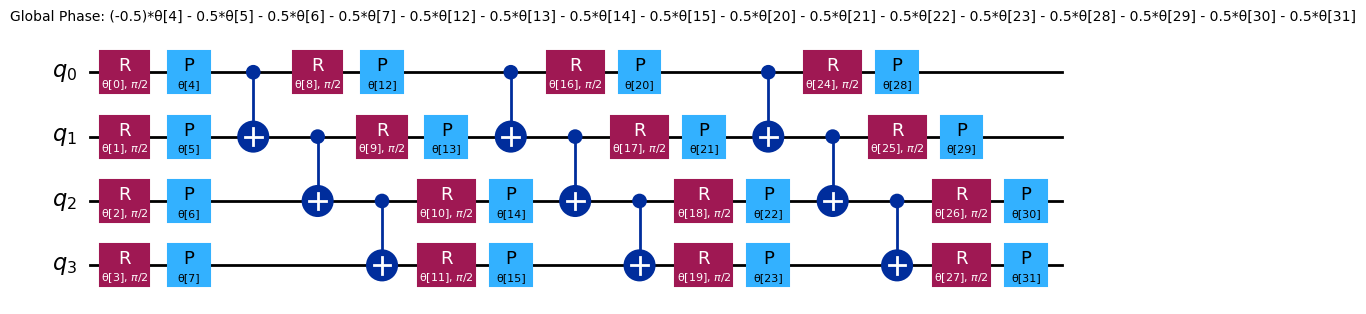

full entanglement:


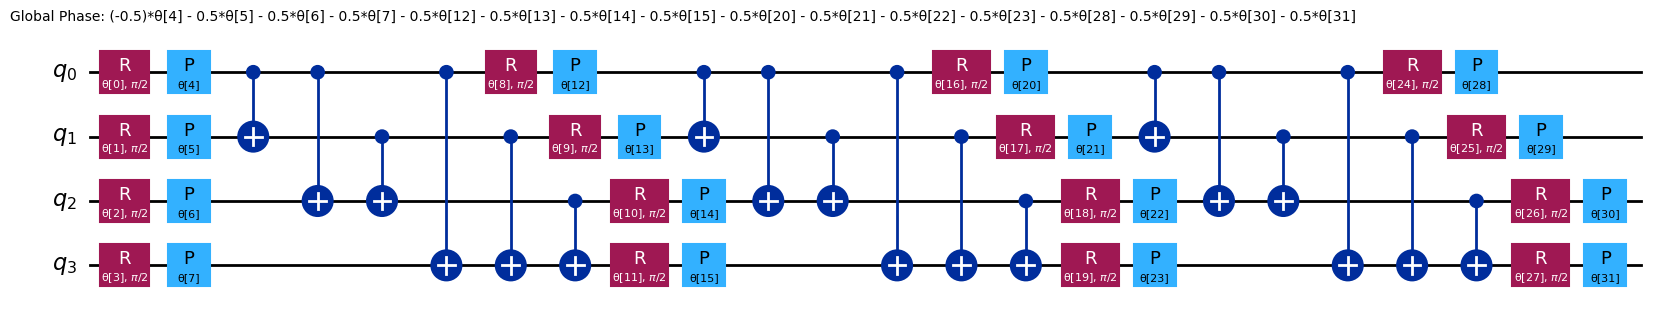

In [13]:
from qiskit.circuit.library import efficient_su2

entanglements = ["linear", "full"]
for entanglement in entanglements:
    form = efficient_su2(num_qubits=4, entanglement=entanglement)
    print(f"{entanglement} entanglement:")
    # We initialize all parameters to 0 for this demonstration
    display(form.decompose().draw("mpl", fold=-1))

Assume the depth setting is set to $d$. Then, RyRz has $2n\times (d+1)$ parameters and Ry (not shown) has $n\times (d+1)$ parameters.

## VQE Implementation in Qiskit

This section illustrates an implementation of VQE using the programmatic approach. Qiskit also enables a declarative implementation, however, it reveals less information about the underlying algorithm. This code, specifically the preparation of qubit operators, is based on the code found in the Qiskit Tutorials repository (and as of July 2019, may be found at: https://github.com/Qiskit/qiskit-tutorials ).

The following libraries must first be imported. 


In [ ]:
# pylint: disable=line-too-long
import qiskit_nature
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

import numpy as np


qiskit_nature.settings.use_pauli_sum_op = False  # pylint: disable=undefined-variable
# pylint: enable=line-too-long
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import efficient_su2

### Running VQE on a Simulator

We demonstrate the calculation of the ground state energy for LiH at various interatomic distances. A driver for the molecule must be created at each such distance. Note that in this experiment, to reduce the number of qubits used, we freeze the core and remove two unoccupied orbitals. First, we define a function that takes an interatomic distance and returns the appropriate qubit operator, $H$, as well as some other information about the operator.

In [15]:
def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["Li", "H"],
        coords=([0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )

    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
        freeze_core=True, remove_orbitals=[-3, -2]
    ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

First, the exact ground state energy is calculated using the qubit operator and a classical exact eigensolver. Subsequently, the initial state $|\psi\rangle$ is created, which the VQE instance uses to produce the final ansatz $\min_{\theta}(|\psi(\theta)\rangle)$. The exact result and the VQE result at each interatomic distance is stored. 

When using an actual quantum device, or a true simulator such as the `AerSimulator` with `VQE(estimator, var_form, optimizer)` the calculation of the expectation value is as follows: A Hamiltonian is represented as a sum of a Pauli strings, with each Pauli term acting on a qubit as specified by the mapping being used. Each Pauli string has a corresponding circuit appended to the circuit corresponding to $|\psi(\theta)\rangle$. Subsequently, each of these circuits is executed, and all of the results are used to determine the expectation value of $H$ on $|\psi(\theta)\rangle$. 

Note that the following code snippet may take a few minutes to run to completion. 

In [ ]:
#THIS TAKES 20 seconds per dist 
from qiskit import transpile
from qiskit_algorithms import VQE
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    return problem.interpret(sol)

# SCAN SETTINGS
distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)


estimator = AerEstimator(
    options={"default_precision": 1e-2*0}   # 0 = exact
)

for dist in distances:      # MAIN LOOP

    # get hamiltonian & problem (your custom function)
    qubit_op, num_particles, num_spatial_orbitals, problem, mapper = get_qubit_op(dist)

    # classical exact
    exact_energy = exact_solver(qubit_op, problem).total_energies[0].real
    exact_energies.append(exact_energy)

    # --- BUILD ANSATZ ---
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)

    ansatz = UCCSD(
        num_spatial_orbitals,
        num_particles,
        mapper,
        initial_state=init_state,
    )

    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )

    # --- CORRECT EXPANSION OF THE CIRCUIT ---
    # convert all evolution ops → standard gates
    ansatz = transpile(
        ansatz,
        basis_gates=["cx", "cz", "h", "p", "sx", "x"],
        optimization_level=1,
    )

    # --- VQE ---
    vqe = VQE(
        estimator=estimator,
        ansatz=ansatz,
        optimizer=optimizer,
        initial_point=[0] * ansatz.num_parameters,
    )

    vqe_result = vqe.compute_minimum_eigenvalue(qubit_op)
    energy = problem.interpret(vqe_result).total_energies[0].real
    vqe_energies.append(energy)

    print(
        f"R = {dist:.2f} Å | VQE = {energy:.6f} | Exact = {exact_energy:.6f}"
    )


print("All energies have been calculated.")

R = 0.50 Å | VQE = -7.047910 | Exact = -7.047910
R = 0.70 Å | VQE = -7.504000 | Exact = -7.504000
R = 0.90 Å | VQE = -7.722835 | Exact = -7.722835
R = 1.10 Å | VQE = -7.825203 | Exact = -7.825203
R = 1.30 Å | VQE = -7.868904 | Exact = -7.868904
R = 1.50 Å | VQE = -7.882140 | Exact = -7.882140
R = 1.70 Å | VQE = -7.879198 | Exact = -7.879198
R = 1.90 Å | VQE = -7.867989 | Exact = -7.867989
R = 2.10 Å | VQE = -7.853196 | Exact = -7.853196
R = 2.30 Å | VQE = -7.837724 | Exact = -7.837724
R = 2.50 Å | VQE = -7.823427 | Exact = -7.823427
R = 2.70 Å | VQE = -7.811420 | Exact = -7.811421
R = 2.90 Å | VQE = -7.802147 | Exact = -7.802147
R = 3.10 Å | VQE = -7.795454 | Exact = -7.795454
R = 3.30 Å | VQE = -7.790845 | Exact = -7.790846
R = 3.50 Å | VQE = -7.787761 | Exact = -7.787761
R = 3.70 Å | VQE = -7.785730 | Exact = -7.785730
R = 3.90 Å | VQE = -7.784406 | Exact = -7.784406
All energies have been calculated.


In [ ]:
#  OLD VERSION ¿? THIS TAKES ~40s  per dist: 10 minutes total (charging)
from qiskit_aer.primitives import EstimatorV2 as AerEstimator

def exact_solver(qubit_op, problem):    #CLASSICAL EIGENSOLVER
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.5, 4.0, 0.2)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)


noiseless_estimator = AerEstimator(options={"default_precision": 1e-2*0})


# pylint: disable=undefined-loop-variable,line-too-long
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )   #LINUX ONLY

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )

    # try one or two decompositions
    ansatz = var_form.decompose()
    ansatz = ansatz.decompose()   # sometimes you need to decompose twice


    vqe = VQE(
        noiseless_estimator,
        ansatz,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

Interatomic Distance: 0.5 VQE Result: -7.04791 Exact Energy: -7.04791
Interatomic Distance: 0.7 VQE Result: -7.50400 Exact Energy: -7.50400
Interatomic Distance: 0.9 VQE Result: -7.72283 Exact Energy: -7.72283
Interatomic Distance: 1.1 VQE Result: -7.82520 Exact Energy: -7.82520
Interatomic Distance: 1.3 VQE Result: -7.86890 Exact Energy: -7.86890
Interatomic Distance: 1.5 VQE Result: -7.88214 Exact Energy: -7.88214
Interatomic Distance: 1.7 VQE Result: -7.87920 Exact Energy: -7.87920
Interatomic Distance: 1.9 VQE Result: -7.86799 Exact Energy: -7.86799
Interatomic Distance: 2.1 VQE Result: -7.85320 Exact Energy: -7.85320
Interatomic Distance: 2.3 VQE Result: -7.83772 Exact Energy: -7.83772
Interatomic Distance: 2.5 VQE Result: -7.82343 Exact Energy: -7.82343
Interatomic Distance: 2.7 VQE Result: -7.81142 Exact Energy: -7.81142
Interatomic Distance: 2.9 VQE Result: -7.80215 Exact Energy: -7.80215
Interatomic Distance: 3.1 VQE Result: -7.79545 Exact Energy: -7.79545
Interatomic Distance

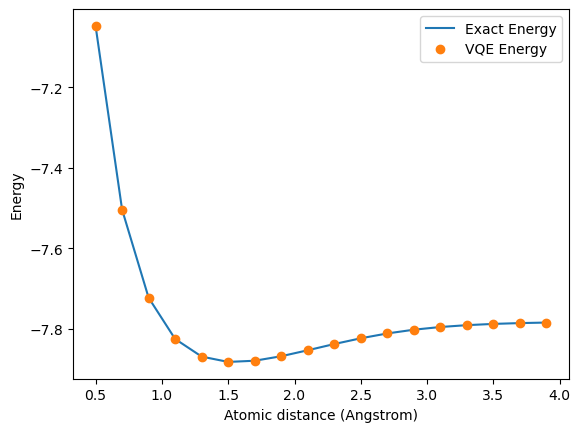

In [18]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, 'o',label="VQE Energy")
plt.xlabel("Atomic distance (Angstrom)")
plt.ylabel("Energy")
plt.legend()
plt.show()

Note that the VQE results are very close to the exact results, and so the exact energy curve is hidden by the VQE curve.

### Running VQE on a Noisy Simulator

Here, we calculate the ground state energy for $H_2$ using a noisy simulator.

First, we prepare the qubit operator representing the molecule's Hamiltonian:

In [19]:
molecule = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["H", "H"],
    coords=([0.0, 0.0, -0.3625], [0.0, 0.0, 0.3625]),
    multiplicity=1,
    charge=0,
)

driver = PySCFDriver.from_molecule(molecule)
problem = driver.run()

second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

mapper = ParityMapper(num_particles=num_particles)  # Set Mapper

hamiltonian = second_q_ops[0]  # Set Hamiltonian

# Do two qubit reduction
qubit_op = mapper.map(hamiltonian)

Now, we load a device coupling map and noise model from the IBM Quantum provider and create a quantum instance:

In [23]:
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeVigoV2


# fake providers contain data from real IBM Quantum devices stored
# in Qiskit Terra, and are useful for extracting realistic noise models.

device = FakeVigoV2()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
noisy_estimator = AerEstimator(
    options={
        "run_options": {
            "noise_model": noise_model,
            "coupling_map": coupling_map,
        }
    }
)

Finally, we must configure the optimizer, the variational form, and the VQE instance. As the effects of noise increase as the number of two qubit gates circuit depth increase, we use a heuristic variational form (RYRZ) rather than UCCSD. RYRZ has a much shallower circuit than UCCSD and uses substantially fewer two qubit gates.

The following code may take a few minutes to run to completion.

In [ ]:
result = exact_solver(qubit_op, problem)
exact_energies.append(result.total_energies)

print("Exact Result:", result.total_energies)
optimizer = SPSA(maxiter=100)   #affects time
var_form = efficient_su2(qubit_op.num_qubits, entanglement="linear")
vqe = VQE(noisy_estimator, var_form, optimizer)
vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
vqe_result = problem.interpret(vqe_calc).total_energies
print("VQE Result:", vqe_result)

Exact Result: [-1.13722138]
VQE Result: [-1.11562152]


As for the noise introduced by real devices (or simulated noise models), it could be tackled through a wide variety of error mitigation techniques. The [Qiskit Runtime Primitives](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/) have enabled error mitigation through the `resilience_level` option. This option is currently available for remote simulators and real backends accessed via the Runtime Primitives, you can consult [this tutorial](https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/Error-Suppression-and-Error-Mitigation.html) for further information.

## Problems

1. You are given a Hamiltonian $H$ with the promise that its ground state is close to a maximally entangled $n$ qubit state. Explain which variational form (or forms) is likely to efficiently and accurately learn the ground state energy of $H$. You may also answer by creating your own variational form, and explaining why it is appropriate for use with this Hamiltonian. 
2. Calculate the number of circuit evaluations performed per optimization iteration, when using the COBYLA optimizer, the `qasm_simulator` with 1000 shots, and a Hamiltonian with 60 Pauli strings.
3. Use VQE to estimate the ground state energy of BeH$_2$ with an interatomic distance of $1.3$Å. You may re-use the function `get_qubit_op(dist)` by replacing `atom="Li .0 .0 .0; H .0 .0 " + str(dist)` with `atom="Be .0 .0 .0; H .0 .0 -" + str(dist) + "; H .0 .0 " + str(dist)` and invoking the function with `get_qubit_op(1.3)`. Note that removing the unoccupied orbitals does not preserve chemical precision for this molecule. However, to get the number of qubits  required down to 6 (and thereby allowing efficient simulation on most laptops), the loss of precision is acceptable. While beyond the scope of this exercise, the interested reader may use qubit tapering operations to reduce the number of required qubits to 7, without losing any chemical precision.

## References

1. Peruzzo, Alberto, et al. "A variational eigenvalue solver on a photonic quantum processor." *Nature communications* 5 (2014): 4213.
2. Griffiths, David J., and Darrell F. Schroeter. Introduction to quantum mechanics. *Cambridge University Press*, 2018.
3. Shende, Vivek V., Igor L. Markov, and Stephen S. Bullock. "Minimal universal two-qubit cnot-based circuits." arXiv preprint quant-ph/0308033 (2003).
4. Kandala, Abhinav, et al. "Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets." Nature 549.7671 (2017): 242.

In [31]:
# # pylint: disable=unused-import
# import qiskit.tools.jupyter

# %qiskit_version_table
import qiskit
print(qiskit.__version__)

2.2.3
